In [1]:
%matplotlib inline

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import scipy.stats as st

from statsmodels.graphics.mosaicplot import mosaic
from pathlib import Path

In [156]:
RANDOM_STATE = 26
INPUT_DATA = "data/ai4i2020.csv"
META_DATA = "data/machine_meta_data.xlsx"

# Predictive Maintenance Draft

## Data

### Description

[description](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)

[paper](https://ieeexplore.ieee.org/document/9253083)

[data](https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv)

synthetic dataset

### Read meta data

In [225]:
machine_meta = pd.read_excel(META_DATA, sheet_name = "features")

### Columns


In [174]:
original_columns = machine_meta[["original_name", "group", "description_short"]]
original_columns

,original_name,group,description_short
0,UDI,na,observation identifier
1,Product ID,product,product numberc (type + unique serial number)
2,Type,product,"product type (H, M, L)"
3,Air temperature [K],process,ambient air temperature in K
4,Process temperature [K],process,process temperature in K
5,Rotational speed [rpm],process,motor speed in rpm
6,Torque [Nm],process,motor torque in Nm
7,Tool wear [min],process,accumulated machining tool wear in min
8,Machine failure,failure,flag that any of the 5 failures has occurred
9,TWF,failure,tool wear failure


## 1. Pre-process

### Read

In [213]:
machine = pd.read_csv(INPUT_DATA)

In [214]:
machine.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

### Get to know

In [215]:
machine.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [216]:
machine.shape

(10000, 14)

In [217]:
machine.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


### Select features

In [218]:
columns_to_keep = machine_meta[machine_meta.keep == "yes"].original_name
machine = machine[columns_to_keep]

### Check for missing values

In [219]:
machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-null  int64  
 11  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [220]:
machine.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Rename columns

In [226]:
new_column_names = machine_meta[machine_meta.keep == "yes"].new_name
new_column_names.name = ""
machine.columns = new_column_names

### Convert types

Convert temperatures from K to C

In [228]:
machine.columns

Index(['product_type', 'air_temperature', 'process_temperature', 'speed',
       'torque', 'tool_wear', 'failure_any', 'failure_toolwear',
       'failure_heatdissipation', 'failure_power', 'failure_overstrain',
       'failure_random'],
      dtype='object', name='')

In [229]:
machine[["air_temperature", "process_temperature"]] = machine[["air_temperature", "process_temperature"]] - 273.15

Convert to category.

In [230]:
machine.product_type = machine.product_type.astype("category")

### Create new feature `elapsed_time`
Total duration of machining calculated by adding up all `tool_wear` durations.

In minutes.

In [231]:
elapsed_time_data = [0]
start_duration = 0

for t in machine.tool_wear[1:]:
    if t == 0:
        start_duration = elapsed_time_data[-1]
    elapsed_time_data.append(t + start_duration)

In [232]:
machine["elapsed_time"] = pd.to_timedelta(elapsed_time_data, unit = "minutes")

### Create new feature `power`
Calculated motor power. Shaft angular speed expressed in radians per second, T expressed in newton-meters.

In [233]:
# Convert speed from rpm to rad
speed_rad = machine.speed * 0.104719755

machine["power"] = speed_rad * machine.torque

### Reorder columns

In [301]:
machine = machine[[
    "elapsed_time",
    "product_type",
    "air_temperature",
    "process_temperature",
    "speed",
    "torque",
    "power",
    "tool_wear",
    "failure_any",
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]]

In [302]:
[print(f"\"{x}\"", end=",\n") for x in machine.columns]
pass

"elapsed_time",
"product_type",
"air_temperature",
"process_temperature",
"speed",
"torque",
"power",
"tool_wear",
"failure_any",
"failure_toolwear",
"failure_heatdissipation",
"failure_power",
"failure_overstrain",
"failure_random",


## 2. Explore

### Proportions
#### Of all parts

Clues:
- Most produced parts are from type `L`.
- Failure occurred for roughly 3% of the total parts.


- product type `L` (low quality) has the highest proportion of failures
- almost 2/3 of all parts are `L`, only 10% are `H` 

In [323]:
def pie_plot_categories(data, title):
    plt.pie(data, labels=data.index, autopct= "%.1f")
    plt.title(title)
    # plt.legend()
    plt.show()

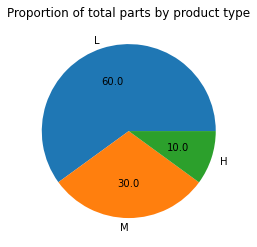

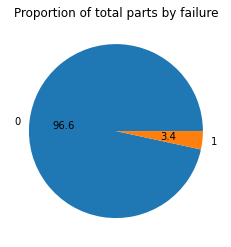

In [325]:
by_product_type = machine.product_type.value_counts()
pie_plot_categories(by_product_type, "Proportion of total parts by product type")

by_failure = machine.failure_any.value_counts()
pie_plot_categories(by_failure, "Proportion of total parts by failure")

#### Of all failures

Observations:
- The proportions by product type are more extreme than the machined proportions. That is, while `L` accounts for $60\%$ of the total volume, it generated approx. $70\%$ of all failures. For `H`: $10\%$ volume vs. $6\%$ failures. 

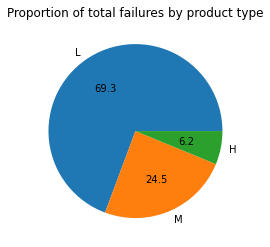

In [327]:
by_product_type = machine[machine.failure_any == 1].product_type.value_counts()
pie_plot_categories(num_failures_by_product_type, "Proportion of total failures by product type")

#### Of all failures by product type

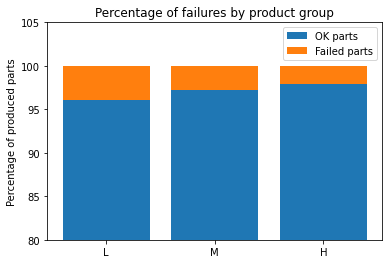

In [238]:
failure_pct = 100 * num_failures_by_product_type / num_parts_by_product_type
ok_pct = 100 - failure_pct

labels = num_failures_by_product_type.index

fig, ax = plt.subplots()

ax.bar(labels, ok_pct, label='OK parts')
ax.bar(labels, failure_pct, bottom=ok_pct, label='Failed parts')

ax.set_ylabel('Percentage of produced parts')
ax.set_title('Percentage of failures by product group')
ax.set_ylim(bottom=80)

ax.legend()
plt.show()

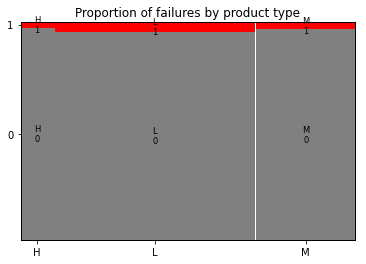

In [286]:
data = machine.groupby(["product_type", "failure_any"]).size()

props = lambda pair: {'color': 'red' if pair[1] == '1' else 'gray', }
mosaic(data=data, properties=props, title="Proportion of failures by product type")
plt.show()

#### Between failure modes

- Heat, power and over-strain account for 80% of the total failures.

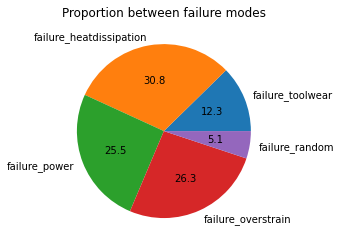

In [333]:
failure_modes = [
    "failure_toolwear",
    "failure_heatdissipation",
    "failure_power",
    "failure_overstrain",
    "failure_random",
]

occurrences = {}
for failure_mode in failure_modes:
    occurrences[failure_mode] = machine[failure_mode].value_counts()[1]
occurrences = pd.Series(occurrences)

pie_plot_categories(occurrences, "Proportion between failure modes", )

### Time series

#### Individual
Clues:
- `air` and `process` temperatures 

In [335]:
hours = machine.elapsed_time.astype('timedelta64[h]')

def plot_individual_timeseries(column):
    plt.plot(hours, machine[column])
    plt.xlabel("Machining time [houts]")
    plt.ylabel(column)
    plt.title(f"Individual timeseries for {column}")
    plt.show()

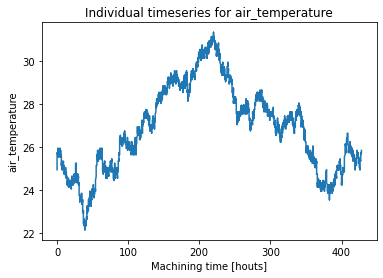

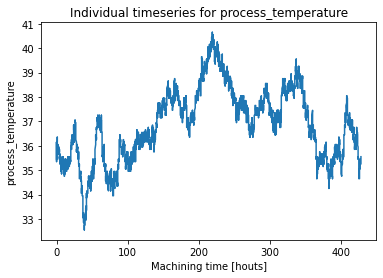

In [336]:
plot_individual_timeseries("air_temperature")
plot_individual_timeseries("process_temperature")

#### Multiple

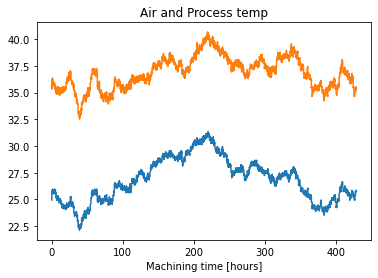

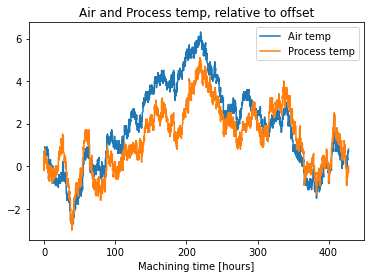

In [337]:
plt.plot(hours, machine.air_temperature, label = "Air temp")
plt.plot(hours, machine.process_temperature, label = "Process temp")
plt.title("Air and Process temp")
plt.xlabel("Machining time [hours]")
plt.show()

plt.plot(hours, machine.air_temperature - machine.air_temperature[1], label = "Air temp")
plt.plot(hours, machine.process_temperature - machine.process_temperature[1], label = "Process temp")
plt.title("Air and Process temp, relative to offset")
plt.xlabel("Machining time [hours]")
plt.legend()
plt.show()

In [243]:
pearson = machine[["air_temperature", "process_temperature"]].corr(method="pearson").iloc[0, 1]
spearman = machine[["air_temperature", "process_temperature"]].corr(method="spearman").iloc[0, 1]
pearson, spearman

(0.8761071581166568, 0.8642172381038954)

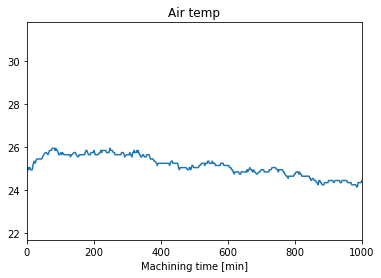

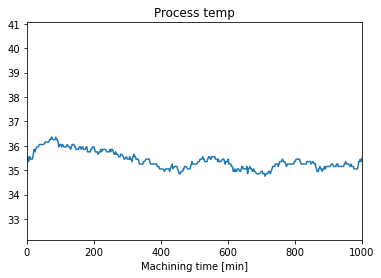

In [245]:
x_limits = (0, 1000)
minutes = machine.elapsed_time.astype('timedelta64[m]')

plt.plot(minutes, machine.air_temperature)
plt.xlabel("Machining time [min]")
plt.title("Air temp")
plt.xlim(x_limits)
plt.show()

plt.plot(minutes, machine.process_temperature)
plt.title("Process temp")
plt.xlabel("Machining time [min]")
plt.xlim(x_limits)
plt.show()

In [246]:
indeces_with_final_tool_life = machine[machine.tool_wear == 0].index[1:] - 1
machine.iloc[indeces_with_final_tool_life].tool_wear.sum()

25663

In [247]:
machine[machine.tool_wear == 0][1:].tool_wear

78      0
162     0
250     0
332     0
418     0
       ..
9672    0
9759    0
9834    0
9908    0
9989    0
Name: tool_wear, Length: 119, dtype: int64

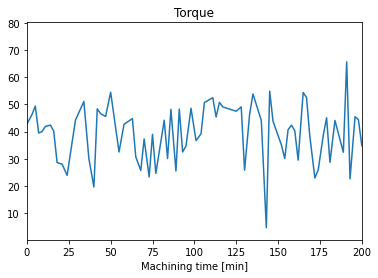

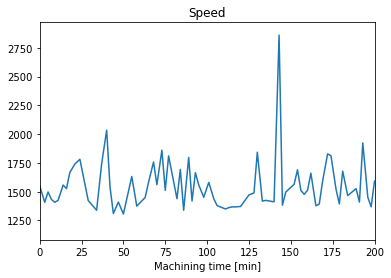

In [248]:
x_limits = (0, 200)

plt.plot(minutes, machine.torque)
plt.title("Torque")
plt.xlabel("Machining time [min]")
plt.xlim(x_limits)
plt.show()

plt.plot(minutes, machine.speed)
plt.title("Speed")
plt.xlabel("Machining time [min]")
plt.xlim(x_limits)
plt.show()

### Distributions
#### Histogram

Clues:
 - `Air` and `process` temperatures does not seem to have normal distribution.
 - `Torque` and `Speed `seem normally distributed.
 - `Speed` distibution is asymmetric: has positive skew of ~2.

In [259]:
# [print(f'"{x}"', end=", ") for x in machine.columns]

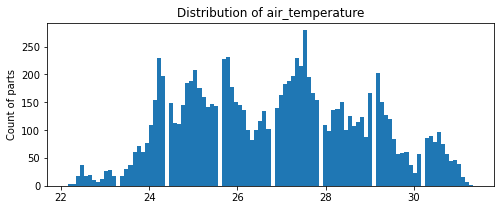

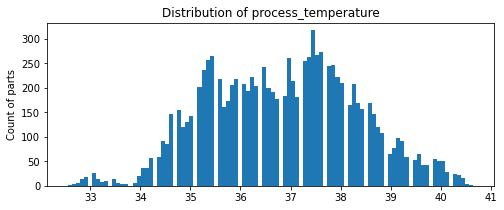

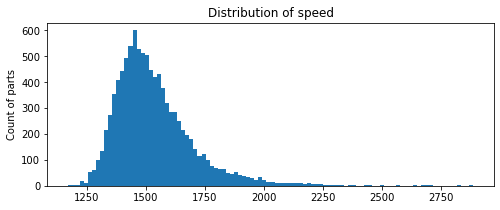

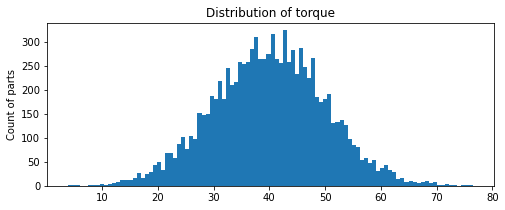

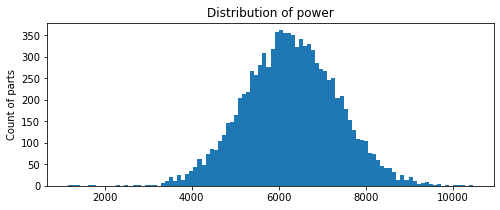

In [260]:
def plot_single_variable_distribution(var, title):
    plt.figure(figsize = (8, 3))
    plt.hist(machine[var], bins=100)
    plt.ylabel("Count of parts")
    plt.title(title)
    plt.show()

variables = ["air_temperature", "process_temperature", "speed", "torque", "power"]
titles = [f"Distribution of {x}" for x in variables]

for variable, title in zip(variables, titles):
    plot_single_variable_distribution(variable, title)

#### Skewness

In [275]:
machine.speed.skew(), machine.torque.skew()

(1.9931710047137523, -0.00951659584005855)

#### Boxplot

Data is normalized to be plotted on one plot.

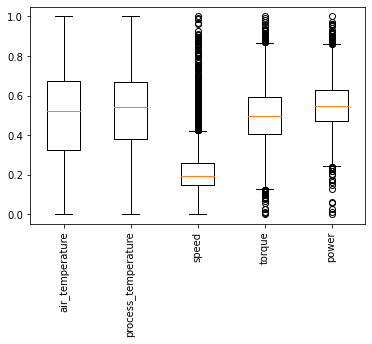

In [274]:
scaler = MinMaxScaler()
machine_cont_variables_scaled = scaler.fit_transform(machine[variables])

plt.boxplot(machine_cont_variables_scaled, labels=variables)
plt.xticks(rotation=90)
plt.show()

### Correlations

Clues:
 - Strong correlations:
 `speed`-`power`, `speed`-`torque`, `process_temp`-`air_temp`.
 - All the above make physical sense.
 - No other corr.

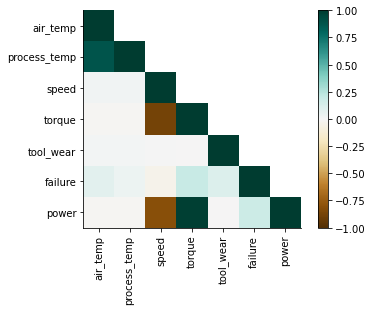

In [30]:
pear_corr = machine.corr()
pear_corr = pear_corr.where(np.tril(np.ones(pear_corr.shape)).astype("bool"))

plt.imshow(pear_corr, cmap='BrBG', vmin=-1, vmax=1)
plt.colorbar()
plt.yticks(range(pear_corr.shape[1]), pear_corr.columns)
plt.xticks(range(pear_corr.shape[1]), pear_corr.columns, rotation='vertical')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

### Compare groups

Clues:
 - No significant difference in the distributions.

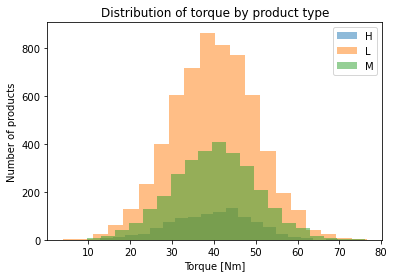

In [31]:
torque_by_product_type = machine.groupby("product_type").torque

for product_type, group_data in torque_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=20)

plt.xlabel("Torque [Nm]")
plt.ylabel("Number of products")
plt.title("Distribution of torque by product type")
plt.legend()
plt.show()

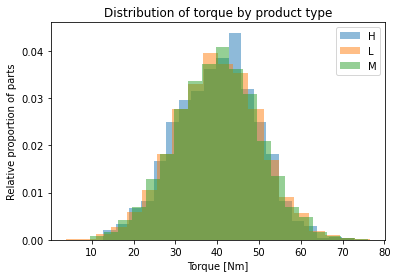

In [32]:
for product_type, group_data in torque_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=20, density=True)

plt.xlabel("Torque [Nm]")
plt.ylabel("Relative proportion of parts")
plt.title("Distribution of torque by product type")
plt.legend()
plt.show()

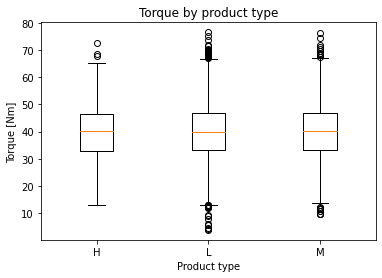

In [33]:
torque_by_product_type_dict = {k: v for k, v in torque_by_product_type}

plt.boxplot(torque_by_product_type_dict.values(),
            labels=torque_by_product_type_dict.keys())

plt.xlabel("Product type")
plt.ylabel("Torque [Nm]")
plt.title("Torque by product type")
plt.show()

power by product type

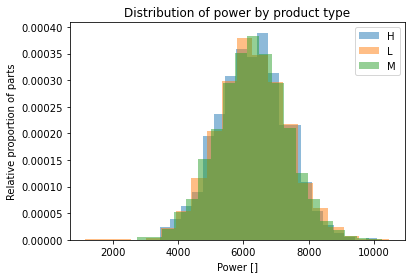

In [34]:
power_by_product_type = machine.groupby("product_type").power

for product_type, group_data in power_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=20, density=True)

plt.xlabel("Power []")
plt.ylabel("Relative proportion of parts")
plt.title("Distribution of power by product type")
plt.legend()
plt.show()

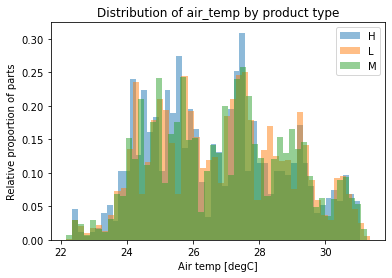

In [35]:
air_temp_by_product_type = machine.groupby("product_type").air_temp

for product_type, group_data in air_temp_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=50, density=True)

plt.xlabel("Air temp [degC]")
plt.ylabel("Relative proportion of parts")
plt.title("Distribution of air_temp by product type")
plt.legend()
plt.show()

### Explore tool replacements and failures

Clues:
- Tool is replaced at roughly regular intervals, approx. 3.5 hours.
- No apparent relationship between failure occurrence and tool replacement.

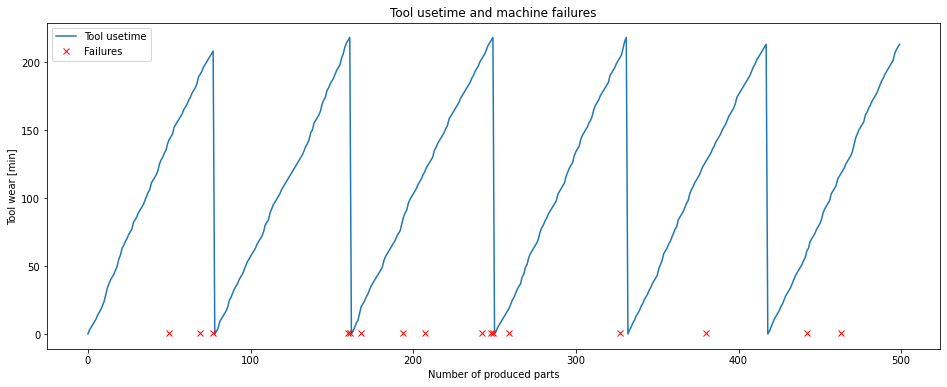

In [239]:
all_failures = machine[machine.failure_any == 1].failure_any

plt.figure(figsize=(16, 6))
plt.plot(machine.tool_wear[:500], label="Tool usetime")
plt.plot(all_failures[all_failures.index < 500], 'rx', label="Failures")
plt.xlabel("Number of produced parts")
plt.ylabel("Tool wear [min]")
plt.title("Tool usetime and machine failures")
plt.legend()
plt.show()

## 3. Test hypotheses

1. Parameter of interest: $\mu_L$, $\mu_M$, $\mu_H$ - the population means of the power for each product type
2. Null hypothesis: $H_0: \mu_L = \mu_M = \mu_H$
3. Alternative hypothesis: the means are different
4. Test statistic: F statistic
5. Reject $H_0$ if: Reject $H_0$ if the p-value is less then 0.05.
6. Computations: 
7. Conclusions:
8. Practical interpretation:

In [36]:
power_by_product_type = machine.groupby("product_type").power

power_L = power_by_product_type.get_group("L")
power_M = power_by_product_type.get_group("M")
power_H = power_by_product_type.get_group("H")

In [37]:
st.f_oneway(power_L, power_M, power_H)

F_onewayResult(statistic=0.13950270083624441, pvalue=0.8697923672178566)

## 4. Model

#### Model 1

Filter columns

In [38]:
machine_for_modeling = machine[['product_type', 'air_temp', 'process_temp', 'speed', 'torque', 'tool_wear', 'failure']]

Add indicator variables

In [39]:
machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

Divide into features and target

In [40]:
machine_features = machine_for_modeling.drop(columns = "failure")
machine_target = machine_for_modeling.failure

Normalize the data

In [41]:
scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_features)

Split to train and test data

In [42]:
features_train, features_test, target_train, target_test = train_test_split(
    machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(7000, 8)
(3000, 8)
(7000,)
(3000,)


Fit Logistic Regression model

In [43]:
model = LogisticRegression()
model.fit(features_train, target_train)

LogisticRegression()

Score the model with test data

In [44]:
score = model.score(features_test, target_test)
score

0.969

Check model coefficients

In [45]:
list(zip(machine_features.columns.to_list(), list(*model.coef_)))

[('air_temp', 3.7946232267817037),
 ('process_temp', -2.298384572728734),
 ('speed', 5.5108587638746025),
 ('torque', 8.493203681272826),
 ('tool_wear', 2.405524150586147),
 ('product_type_H', -0.49660240182507787),
 ('product_type_L', 0.3448044500118035),
 ('product_type_M', 0.1520560643016155)]

Predict single records and compare

In [46]:
rand_x = [429, 540, 500]

for x in rand_x:
    random_input = features_test[x,:].reshape(1, -1)
    random_response = target_test.iloc[x]

    print("index: ", x, ", expected: ", model.predict(random_input)[0], ", actual: ", random_response)

index:  429 , expected:  0 , actual:  1
index:  540 , expected:  0 , actual:  0
index:  500 , expected:  0 , actual:  0


#### Model 2

Added `power`

In [47]:
machine_for_modeling = machine[['product_type', 'air_temp', 'process_temp', 'speed', 'torque', 'tool_wear', 'failure', 'power']]

machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

machine_features = machine_for_modeling.drop(columns = "failure")
machine_target = machine_for_modeling.failure

scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_features)

features_train, features_test, target_train, target_test = train_test_split(
    machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = 42)

model = LogisticRegression()
model.fit(features_train, target_train)

score = model.score(features_test, target_test)
print(f"Score: {score}")

print("----------------------")

print("Model coefficients:")
coeffs = [str(x) for x in zip(machine_features.columns.to_list(), list(*model.coef_))]
print("\n".join(coeffs))

Score: 0.9693333333333334
----------------------
Model coefficients:
('air_temp', 3.8138278949125954)
('process_temp', -2.3138011031554493)
('speed', 5.808999495125304)
('torque', 7.040837932865518)
('tool_wear', 2.428744252894368)
('power', 2.3822623475922486)
('product_type_H', -0.4993391964945984)
('product_type_L', 0.34548422680130414)
('product_type_M', 0.153270777680036)


#### Model 3

- Added `power`
- Removed `speed` and `torque`

In [48]:
machine_for_modeling = machine[['product_type', 'air_temp', 'process_temp', 'tool_wear', 'failure', 'power']]

machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

machine_features = machine_for_modeling.drop(columns = "failure")
machine_target = machine_for_modeling.failure

scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_features)

features_train, features_test, target_train, target_test = train_test_split(
    machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = 42)

model = LogisticRegression()
model.fit(features_train, target_train)

score = model.score(features_test, target_test)
print(f"Score: {score}")

print("----------------------")

print("Model coefficients:")
coeffs = [str(x) for x in zip(machine_features.columns.to_list(), list(*model.coef_))]
print("\n".join(coeffs))

Score: 0.969
----------------------
Model coefficients:
('air_temp', 3.797196450482926)
('process_temp', -2.3005656916930817)
('tool_wear', 2.366861604199966)
('power', 6.143974266555787)
('product_type_H', -0.5098467222265894)
('product_type_L', 0.3530788782614438)
('product_type_M', 0.15853397139884062)


#### Model 4

- Added `power`
- Removed `speed` and `torque`

In [49]:
machine_for_modeling = machine[['product_type', 'air_temp', 'process_temp', 'tool_wear', 'failure', 'power']]

machine_for_modeling = pd.get_dummies(machine_for_modeling, columns=["product_type"])

machine_features = machine_for_modeling.drop(columns = "failure")
machine_target = machine_for_modeling.failure

scaler = MinMaxScaler()
machine_features_scaled = scaler.fit_transform(machine_features)

features_train, features_test, target_train, target_test = train_test_split(
    machine_features_scaled, machine_target, train_size = 0.7, test_size = 0.3, random_state = 42)

model = LogisticRegression()
model.fit(features_train, target_train)

score = model.score(features_test, target_test)
print(f"Score: {score}")

print("----------------------")

print("Model coefficients:")
coeffs = [str(x) for x in zip(machine_features.columns.to_list(), list(*model.coef_))]
print("\n".join(coeffs))

Score: 0.969
----------------------
Model coefficients:
('air_temp', 3.797196450482926)
('process_temp', -2.3005656916930817)
('tool_wear', 2.366861604199966)
('power', 6.143974266555787)
('product_type_H', -0.5098467222265894)
('product_type_L', 0.3530788782614438)
('product_type_M', 0.15853397139884062)


## PCA

Observations:
- The first 3 principle components account for almost 90% of the total variance.

In [117]:
pca = PCA().fit(machine_features_scaled)

In [118]:
total_variance = np.sum(pca.singular_values_ ** 2)
explained_variance = np.array([(x ** 2 / total_variance) for x in pca.singular_values_])
cumulative_explained_variance = np.cumsum(explained_variance)

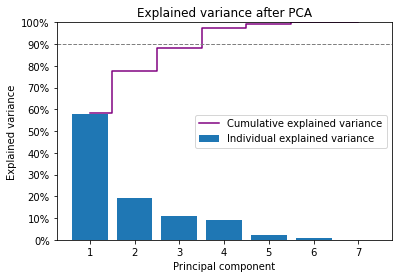

In [127]:
fig, ax = plt.subplots()

x = np.arange(1, 1 + len(explained_variances))

plot1 = ax.bar(x = x, height = explained_variance.round(2), align='center', label='Individual explained variance')
plot2 = ax.step(x = x, y = cumulative_explained_variance, color = 'purple', where='mid', label='Cumulative explained variance')

plt.axhline(0.9, linestyle = "--", linewidth = 1, color = "gray")
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.title("Explained variance after PCA")
plt.yticks(ticks = np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.legend()
plt.show()

In [154]:
machine_features_scaled_pca = PCA(n_components=3).fit_transform(machine_features_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    machine_features_scaled_pca, machine_target, test_size = 0.3, train_size = 0.7, random_state = 42)


model = LogisticRegression()

model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Score: {score}")

Score: 0.969
